# Prophet on Total Sales (Units Sold) with Explanatory Variables

In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import logging
import itertools
%matplotlib inline

In [304]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [306]:
def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    
    smape = 100 * np.mean(numerator / (denominator + 1e-10 ))
    return smape

In [307]:
df = pd.read_csv('../dataset/clustered_data.csv')

In [308]:
total_df = df.groupby('Date')[['UnitsSold', 'AveragePricePerUnitPounds']].sum().reset_index()
total_df = total_df.rename(columns={'Date': 'date', 'UnitsSold': "y"})

In [309]:
explanatory_df = pd.read_csv('../explanatory_variables/combined_explanatory_variables.csv')

In [310]:
total_df = total_df.merge(explanatory_df, on='date', how='left')

In [311]:
total_df = total_df.rename(columns={'date': 'ds'})
total_df['ds'] = pd.to_datetime(total_df['ds'])

In [312]:
regressors = ['AveragePricePerUnitPounds', 'gift_ideas',
       'chained-volume-percentage-change-3-months-on-same-period-a-year-earlier',
       'chained-volume-percentage-change-on-previous-month',
       'chained-volume-percentage-change-on-same-month-a-year-earlier',
       'current-prices-percentage-change-on-previous-month',
       'current-prices-percentage-change-on-same-month-a-year-earlier',
       'is_black_friday', 'is_cyber_monday', 'cpi', 'cci', 'interest_rate',
       'unemployment_rate', 'is_holiday', 'is_Friday', 'is_Monday',
       'is_Saturday', 'is_Sunday', 'is_Thursday', 'is_Tuesday',
       'is_Wednesday']

In [313]:
n = len(total_df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train_data = total_df.iloc[:train_end]
validation_data = total_df.iloc[train_end:val_end]
test_data = total_df.iloc[val_end:]

In [314]:
clip_threshold = np.percentile(total_df['y'], 99)

In [315]:
model = Prophet()

for reg in regressors:
    model.add_regressor(reg)
    
model.fit(train_data)

## Validation

In [316]:
validation_forecast = model.predict(validation_data)

In [ ]:
actual_values = np.array(validation_data['y'])
predicted_values = np.array(validation_forecast['yhat'])

1.597353686227766e+20

In [318]:
validation_smape = calculate_smape(actual_values, predicted_values)
validation_smape

40.751291496130335

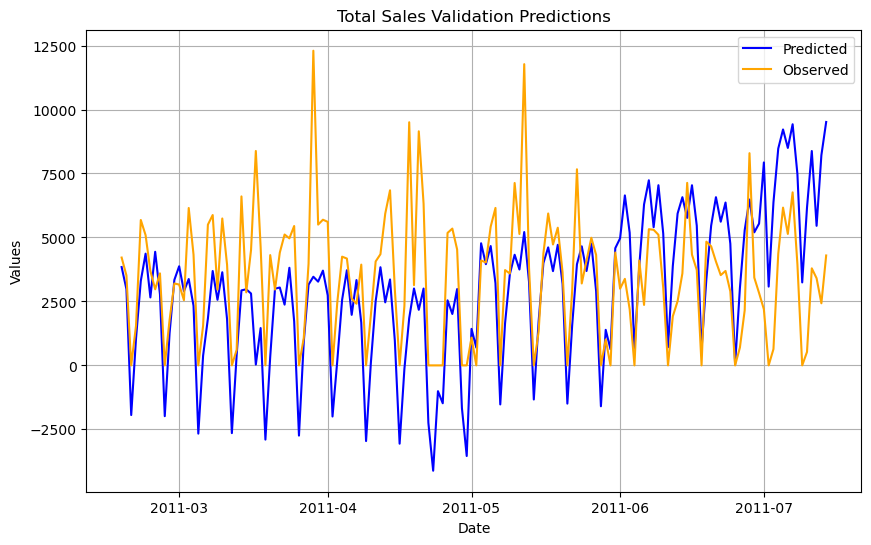

In [319]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(validation_data['ds']), validation_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(validation_data['ds']), validation_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Validation Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Test

In [320]:
test_forecast = model.predict(test_data)

In [ ]:
actual_values = np.array(test_data['y'])
predicted_values = np.array(test_forecast['yhat'])

4.0639594221900123e+20

In [322]:
test_smape = calculate_smape(actual_values, predicted_values)
test_smape

52.55683362366508

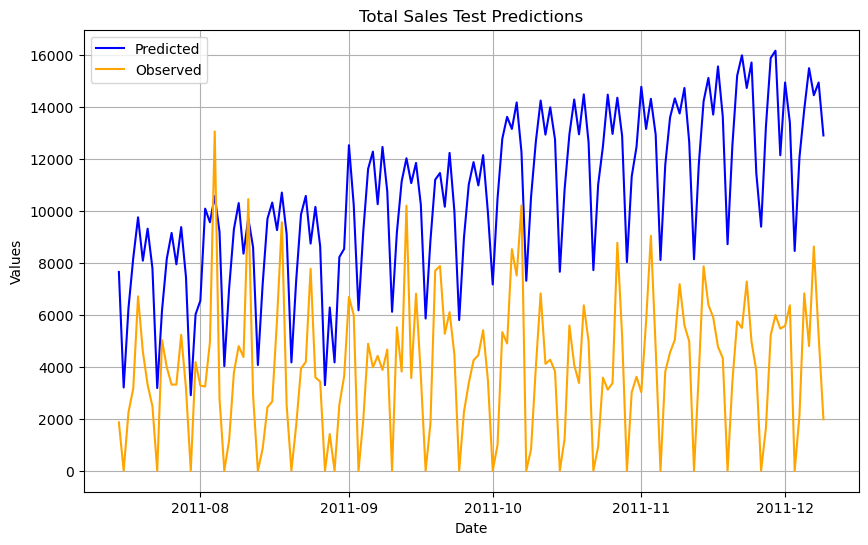

In [323]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(test_data['ds']), test_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(test_data['ds']), test_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Overall

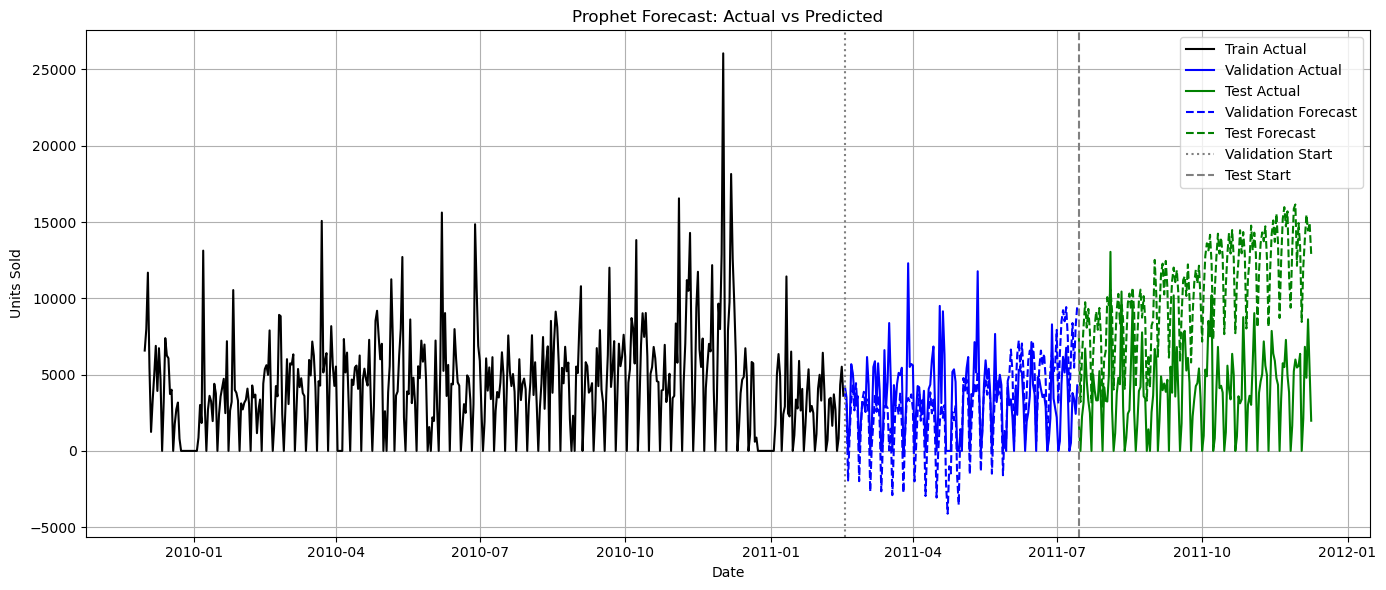

In [324]:
plt.figure(figsize=(14, 6))

plt.plot(train_data['ds'], train_data['y'], label='Train Actual', color='black')
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Actual', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='green')

plt.plot(validation_forecast['ds'], validation_forecast['yhat'], label='Validation Forecast', color='blue', linestyle='--')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Test Forecast', color='green', linestyle='--')

plt.axvline(x=validation_data['ds'].min(), color='gray', linestyle=':', label='Validation Start')
plt.axvline(x=test_data['ds'].min(), color='gray', linestyle='--', label='Test Start')

plt.title('Prophet Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Tuning

In [325]:
param_grid = {
    "changepoint_prior_scale": [0.01, 0.05, 0.1, 0.2, 0.5],
    "seasonality_prior_scale": [0.05, 0.1, 0.5, 1, 5],
    "fourier_order": [3, 5, 10]
}

best_smape = float("inf")
best_params = None
best_model = None

In [326]:
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
validation_data = validation_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
# Grid search loop
for cps, sps, fo in itertools.product(
    param_grid["changepoint_prior_scale"],
    param_grid["seasonality_prior_scale"],
    param_grid["fourier_order"]
):
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps
    )

    # Add custom monthly seasonality
    model.add_seasonality(name="monthly", period=30.5, fourier_order=fo)

    for reg in regressors:
        model.add_regressor(reg)

    try:
        # Fit model
        model.fit(train_data)

        # Predict on test
        future = validation_data[['ds'] + regressors]
        forecast = model.predict(future)

        # Evaluate
        y_true = validation_data["y"]
        y_pred = np.clip(forecast["yhat"], 0, clip_threshold)

        smape = calculate_smape(y_true, y_pred)

        print(f"cps={cps}, sps={sps}, fo={fo}: SMAPE={smape:.2f}%")

        if smape < best_smape:
            best_smape = smape
            best_params = (cps, sps, fo)
            best_model = model

    except Exception as e:
        print(f"⚠️ Skipping params (cps={cps}, sps={sps}, fo={fo}) due to error: {e}")

cps=0.01, sps=0.05, fo=3: SMAPE=36.32%
cps=0.01, sps=0.05, fo=5: SMAPE=36.30%
cps=0.01, sps=0.05, fo=10: SMAPE=36.92%
cps=0.01, sps=0.1, fo=3: SMAPE=38.59%
cps=0.01, sps=0.1, fo=5: SMAPE=34.97%
cps=0.01, sps=0.1, fo=10: SMAPE=36.52%
cps=0.01, sps=0.5, fo=3: SMAPE=38.80%
cps=0.01, sps=0.5, fo=5: SMAPE=38.64%
cps=0.01, sps=0.5, fo=10: SMAPE=35.67%
cps=0.01, sps=1, fo=3: SMAPE=39.27%
cps=0.01, sps=1, fo=5: SMAPE=38.24%
cps=0.01, sps=1, fo=10: SMAPE=39.73%
cps=0.01, sps=5, fo=3: SMAPE=37.26%
cps=0.01, sps=5, fo=5: SMAPE=36.46%
cps=0.01, sps=5, fo=10: SMAPE=35.31%
cps=0.05, sps=0.05, fo=3: SMAPE=33.05%
cps=0.05, sps=0.05, fo=5: SMAPE=32.94%
cps=0.05, sps=0.05, fo=10: SMAPE=33.05%
cps=0.05, sps=0.1, fo=3: SMAPE=34.14%
cps=0.05, sps=0.1, fo=5: SMAPE=35.18%
cps=0.05, sps=0.1, fo=10: SMAPE=33.79%
cps=0.05, sps=0.5, fo=3: SMAPE=38.16%
cps=0.05, sps=0.5, fo=5: SMAPE=36.44%
cps=0.05, sps=0.5, fo=10: SMAPE=34.06%
cps=0.05, sps=1, fo=3: SMAPE=37.13%
cps=0.05, sps=1, fo=5: SMAPE=35.94%
cps=0.05, sps=

In [328]:
print(f"\n✅ Best Parameters: changepoint_prior_scale={best_params[0]}, "
      f"seasonality_prior_scale={best_params[1]}, fourier_order={best_params[2]}")
print(f"📉 Best SMAPE on Validation Set: {best_smape:.2f}%")

best_test_forecast = best_model.predict(test_data[["ds"]+regressors])
best_test_forecast['yhat'] = np.clip(best_test_forecast['yhat'], 0, clip_threshold)
best_validation_forecast = best_model.predict(validation_data[["ds"] + regressors])
best_validation_forecast['yhat'] = np.clip(best_validation_forecast['yhat'], 0, clip_threshold)


✅ Best Parameters: changepoint_prior_scale=0.2, seasonality_prior_scale=0.05, fourier_order=10
📉 Best SMAPE on Validation Set: 20.87%


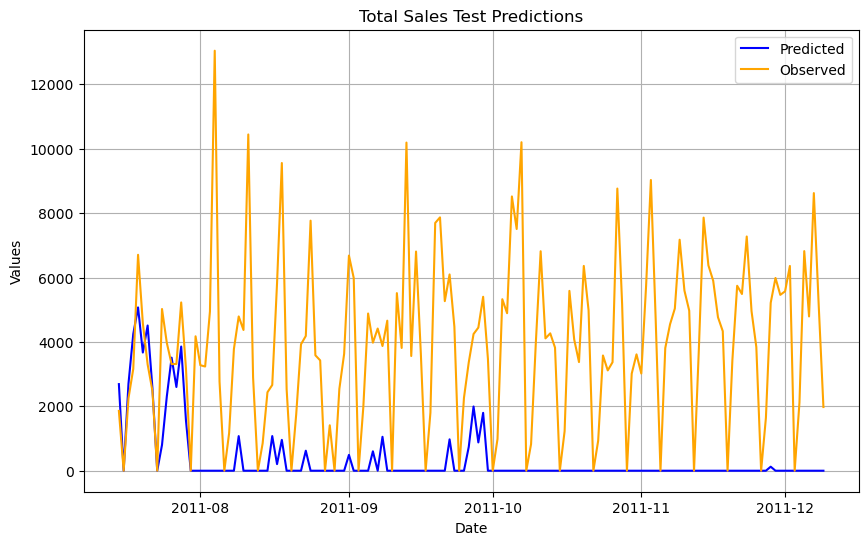

In [329]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(test_data['ds']), best_test_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(test_data['ds']), test_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

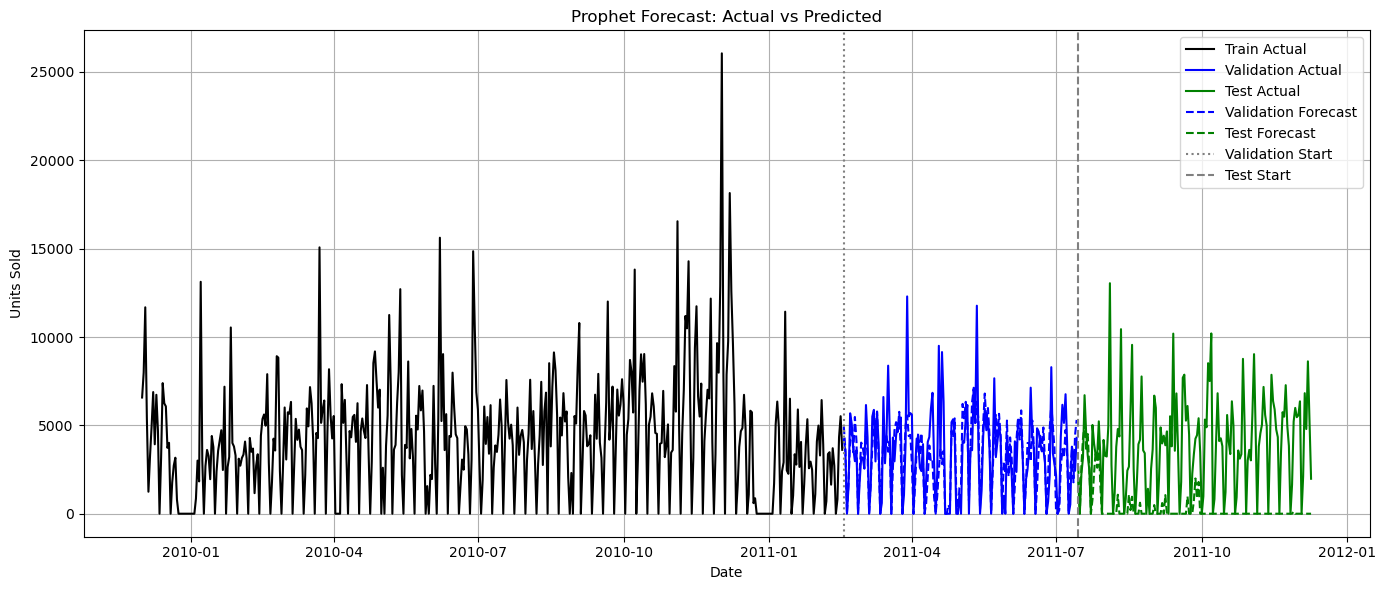

In [330]:
plt.figure(figsize=(14, 6))

plt.plot(train_data['ds'], train_data['y'], label='Train Actual', color='black')
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Actual', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='green')

plt.plot(best_validation_forecast['ds'], best_validation_forecast['yhat'], label='Validation Forecast', color='blue', linestyle='--')
plt.plot(best_test_forecast['ds'], best_test_forecast['yhat'], label='Test Forecast', color='green', linestyle='--')

plt.axvline(x=validation_data['ds'].min(), color='gray', linestyle=':', label='Validation Start')
plt.axvline(x=test_data['ds'].min(), color='gray', linestyle='--', label='Test Start')

plt.title('Prophet Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
